In [37]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm
from scipy import sparse

import netket as nk
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import json

PATH = os.getcwd()

### Generate Table of All Possible States Indexed in Lexigraphical Order

In [38]:
def generateStateTable(n,n0,N): # assumes ab > n0 > 0 and N = n choose n0
    states = []
    state = np.concatenate((np.ones(n-n0),-1*np.ones(n0))).astype(int)
    for i in range(0,N):
        states.append(np.copy(state))
        j = 0
        flag = True
        flip_count = 0
        up_count = 0
        while (flag): 
            if (j == n-1):
                for m in range(0,n):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                if (flip_count == 1):
                    break
            if (state[j] != 1):
                j += 1  
            elif (state[j+1] != 1):
                for m in range(0,j):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                    if (state[m] == 1):
                        up_count += 1
                if (flip_count == 1):
                    state[j],state[j+1] = state[j+1],state[j]
                    for k in range(1,up_count+1):
                        state[j-k],state[k-1] = state[k-1],state[j-k]
                else:
                    state[j],state[j+1] = state[j+1],state[j]
                flag = False
            else:
                j += 1
    return states

### Generate Adjacency Matrices

In [39]:
class Node:
    def __init__(self, position, xadj, yadj):
        self.position = position
        self.xadj = xadj
        self.yadj = yadj
    
    def __str__(self):
        return f"{self.position} {self.xadj} {self.yadj}"

In [40]:
def squareAdjacencyList(a,b): # constructs a periodic adjacency graph with width a and height b
    nodes = []
    
    for i in range(0,a):
        for j in range(0,b):
            xadj = [[i-1 % a,j],[i+1 % a,j]]
            yadj = [[i,j-1 % b],[i,j+1 % b]]
            nodes.append(Node([[i,j]],xadj,yadj))

    return nodes

### First Neighbors Adjacency Matrix

In [41]:
def firstneighbors(a,b): 
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False
            for xptr in nodes[i].xadj:
                if xptr in nodes[j].position:
                    flag = True
            for yptr in nodes[i].yadj:
                if yptr in nodes[j].position:
                    flag = True
            if flag:
                J[i][j] = 1
                J[j][i] = 1
        
    return np.array(J)

### Second Neighbors (Euclidean) Adjacency Matrix

In [42]:
def secondneighbors(a,b):
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False

            for xptr in nodes[i].xadj:
                try:
                    for k in range(0,N):
                        if xptr in nodes[k].position:
                            intermediate = k
                    for yptr in nodes[intermediate].yadj:
                        if yptr in nodes[j].position:
                            flag = True
                except UnboundLocalError:
                    pass

            if flag:
                J[i][j] = 1
                J[j][i] = 1

    return np.array(J)

### Model Parameters

In [43]:
a = 4 # x-range of supercell
b = 4 # y-range of supercell
N1 = firstneighbors(a,b)
N2 = secondneighbors(a,b)
n = a*b # number of sites in lattice

n0 = n // 2 # number of down spins in the string (taken as floor(n/2))
N = int(math.factorial(n)/(math.factorial(n0)*math.factorial(n-n0))) # number of states

stateTable = generateStateTable(n,n0,N)

### Compute Hamiltonian of the System

In [44]:
def computeHamiltonian(J1,J2):
    # uses the fact that the Hamiltonian is real and Hermitian => symmetric
    row = []
    col = []
    data = []

    for i in range(0,N):
        for j in range(i,N):
            if (i == j):
                for k in range(0,n-1):
                    for l in range(k+1,n):
                        if (N1[k][l] != 0):
                            row.append(i)
                            col.append(j)
                            data.append(J1*stateTable[i][k]*stateTable[i][l])
                        if (N2[k][l] != 0):
                            row.append(i)
                            col.append(j)
                            data.append(J2*stateTable[i][k]*stateTable[i][l])
                        
            else:
                tempState = np.multiply(stateTable[i],stateTable[j])
                if (np.count_nonzero(tempState == -1) == 2):
                    indices = np.where(tempState == -1)
                    e,f = indices[0][0],indices[0][1]
                    if (N1[e][f] != 0):
                        row.append(i)
                        col.append(j)
                        data.append(2*J1)
                        row.append(j)
                        col.append(i)
                        data.append(2*J1)
                    if (N2[e][f] != 0):
                        row.append(i)
                        col.append(j)
                        data.append(2*J2)
                        row.append(j)
                        col.append(i)
                        data.append(2*J2)
    
    H = sparse.coo_array((data, (row, col)), shape=(N,N), dtype=np.float32)
    return H

### Load Hamiltonian

In [45]:
# H = sparse.load_npz(PATH + '/n20hamiltonian.npz')

### Iterate over Multiple J1/J2

In [46]:
def firstSpinCorrelation(states,n):
    spin_corr = 0
    for i in range(0,len(states)):
        sCorr = 0
        for k in range(0,n-1):
            for l in range(k+1,n):
                if (N1[k][l] != 0):
                    sCorr += stateTable[i][k]*stateTable[i][l]
        spin_corr += (states[i][0]**2)*sCorr

    numNeighbors = 0
    for i in range(0,len(N1)):
        for j in range(0,len(N1[0])):
            numNeighbors += N1[i][j]
    spin_corr /= (numNeighbors/2)
    return spin_corr

def process(J1,J2):
    H = computeHamiltonian(J1,J2)
    # H = sparse.load_npz(PATH + '/J1='+str(round(J1,3))+'.J2='+str(round(J2,3))+'hamiltonian.npz')
    # print(H.toarray())
    
    sparse.save_npz(PATH + '/J1='+str(round(J1,3))+'.J2='+str(round(J2,3))+'hamiltonian.npz', H, compressed=True)

    numEnergies = 1
    energies, states = sparse.linalg.eigs(H.asfptype(), k=numEnergies, which='SR')
    energies = np.real(energies)
    states = np.real(states)

    firstSpinCorr = firstSpinCorrelation(states,n)

    return energies[0]/n,firstSpinCorr

In [47]:
stepint = 0.01 # interval size

J2s = np.arange(1, 2, stepint)
grdEs = []
sCorrs = []

for i in range(0,len(J2s)):
    grdE,sCorr = process(1,J2s[i])
    grdEs.append(grdE)
    sCorrs.append(sCorr)

print(grdEs)
print(sCorrs)

[-2.005661964416504, -2.0174920558929443, -2.0293898582458496, -2.0413737297058105, -2.0534603595733643, -2.065694570541382, -2.078139066696167, -2.0909268856048584, -2.104274034500122, -2.1184470653533936, -2.133594512939453, -2.1495697498321533, -2.1660983562469482, -2.182964324951172, -2.2000420093536377, -2.2172601222991943, -2.2345781326293945, -2.2519705295562744, -2.2694203853607178, -2.286921739578247, -2.3044652938842773, -2.3220415115356445, -2.339647054672241, -2.357278823852539, -2.374952554702759, -2.3926353454589844, -2.4103448390960693, -2.428077459335327, -2.4458227157592773, -2.463594675064087, -2.4813787937164307, -2.4991862773895264, -2.517003297805786, -2.5348432064056396, -2.552691698074341, -2.570554733276367, -2.588430404663086, -2.6063201427459717, -2.624228000640869, -2.6421408653259277, -2.6600682735443115, -2.678008556365967, -2.695962905883789, -2.7139248847961426, -2.73189115524292, -2.749870777130127, -2.767866373062134, -2.785867929458618, -2.803873300552

### Visualize Data

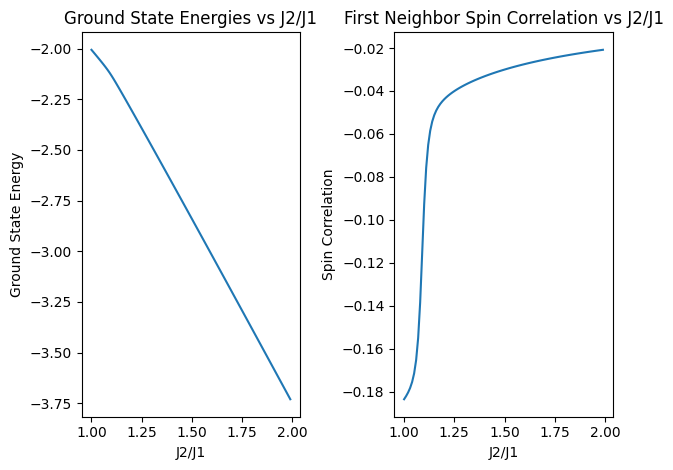

In [48]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(J2s,grdEs)
ax[0].set_title("Ground State Energies vs J2/J1")
ax[0].set_xlabel("J2/J1")
ax[0].set_ylabel("Ground State Energy")

ax[1].plot(J2s,sCorrs)
ax[1].set_title("First Neighbor Spin Correlation vs J2/J1")
ax[1].set_xlabel("J2/J1")
ax[1].set_ylabel("Spin Correlation")

plt.tight_layout()
plt.show()
